In [1]:
import keras
from keras import layers
import matplotlib.pyplot as plt
from keras.datasets import cifar10

2024-02-13 19:41:34.641940: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 19:41:34.662502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 19:41:34.662524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 19:41:34.663248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 19:41:34.667021: I tensorflow/core/platform/cpu_feature_guar

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print(x_train.shape)
print(f"Range of image data: {x_train.min(), x_train.max()}")
# Let's normalize, to 0-1 floats:
# keep in mind we always need to perform same operations to test set,
# which we've already split off above
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255
print(f"New range: {x_train.min(), x_train.max()}")


(50000, 32, 32, 3)
Range of image data: (0, 255)
New range: (0.0, 1.0)


In [4]:
print(y_train.shape)
from keras.utils import to_categorical
# We need to convert the classes to categorical distributions (they are currently ints)
print(y_train[0])
if y_train.shape[1] == 1:
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
print(y_train[0])
print(y_train.shape)

(50000, 1)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
(50000, 10)


In [5]:
import numpy as np
n_classes = y_train.shape[1]
print(f"There are {n_classes} classes in this dataset, based on the number of unique labels.")
class_num_to_str = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

There are 10 classes in this dataset, based on the number of unique labels.


Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
According to the labeled dataset, this is a airplane.


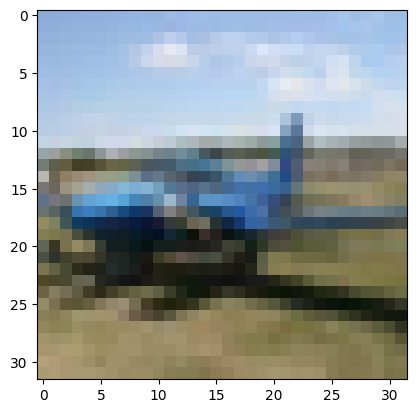

In [6]:
idx = 453
plt.imshow(x_train[idx])
print(f'Label: {y_train[idx]}')
# Convert back to int:
class_num = np.argmax(y_train[idx])
print(f'Label: {class_num}')
print(f"According to the labeled dataset, this is a {class_num_to_str[class_num]}.")

In [7]:
# Let's build a simple convolutional neural network to train on CIFAR-10
model = keras.Sequential(
    [
        keras.Input(shape=x_train[0].shape),
        layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        layers.Dropout(0.25),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.BatchNormalization(),
        layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.Dropout(0.35),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ]
)

2024-02-13 19:41:36.118880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 19:41:36.140098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 19:41:36.140202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9

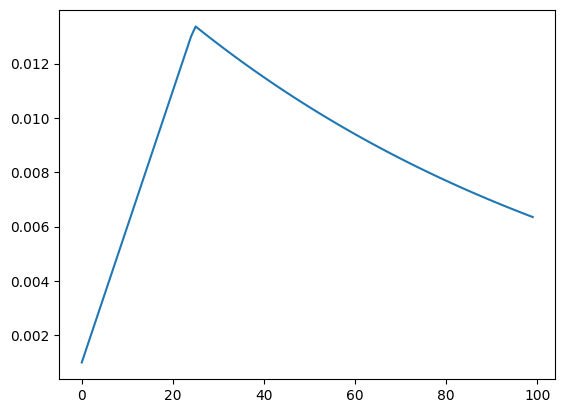

In [9]:
initial_lr = 1e-3

def schedule(epoch):
    drop_epoch = 25
    if epoch < drop_epoch:
        # increase lr:
        return initial_lr + 0.0005 * epoch
    # Every 5 epochs, reduce lr by 50%:
    drop_rate = 0.99
    last_lr_before_drop = initial_lr + 0.0005 * drop_epoch
    epoch_rate = 1
    return last_lr_before_drop * drop_rate**((epoch - drop_epoch)//epoch_rate + 1)

# Plot the learning rate schedule:
plt.plot([schedule(i) for i in range(100)])
# plt.yscale('log')
plt.show()

In [10]:

optimizer = keras.optimizers.Adam(learning_rate=initial_lr)


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 1024
epochs = 200
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2,
                    batch_size=batch_size,
                    callbacks=[keras.callbacks.LearningRateScheduler(schedule)]
                    )

Epoch 1/100


2024-02-13 19:41:37.283645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-13 19:41:37.410821: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-13 19:41:38.202121: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f68a8fbeca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-13 19:41:38.202136: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-13 19:41:38.205022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707871298.244613  751119 device_compiler.h:186] Compiled cluster using XL

40/40 [==============================] - 8s 73ms/step - loss: 2.1091 - accuracy: 0.2286 - val_loss: 2.2362 - val_accuracy: 0.1375 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 1s 24ms/step - loss: 1.6328 - accuracy: 0.3932 - val_loss: 2.4770 - val_accuracy: 0.1190 - lr: 0.0015
Epoch 3/100
40/40 [==============================] - 1s 23ms/step - loss: 1.4359 - accuracy: 0.4758 - val_loss: 4.0307 - val_accuracy: 0.0982 - lr: 0.0020
Epoch 4/100
40/40 [==============================] - 1s 23ms/step - loss: 1.3377 - accuracy: 0.5163 - val_loss: 3.3940 - val_accuracy: 0.1082 - lr: 0.0025
Epoch 5/100
40/40 [==============================] - 1s 24ms/step - loss: 1.2587 - accuracy: 0.5501 - val_loss: 7.9949 - val_accuracy: 0.0980 - lr: 0.0030
Epoch 6/100
40/40 [==============================] - 1s 23ms/step - loss: 1.1985 - accuracy: 0.5731 - val_loss: 4.1692 - val_accuracy: 0.1974 - lr: 0.0035
Epoch 7/100
40/40 [==============================] - 1s 24ms/step - loss: 1.1468 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


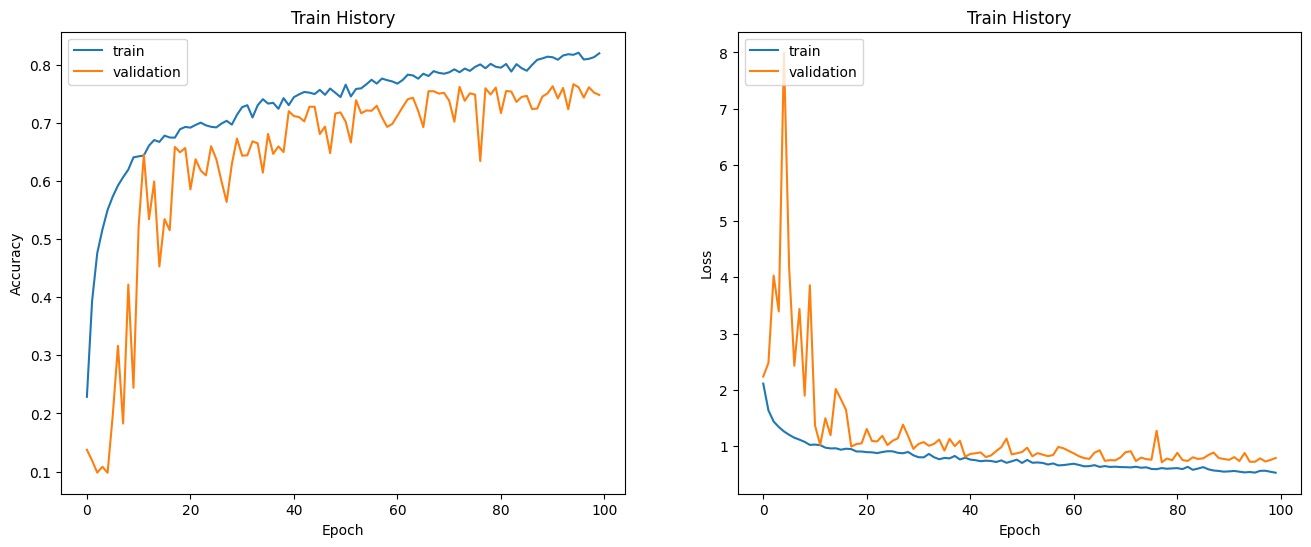

In [11]:
import sys
sys.path.append("../../Code")

from utils import show_train_history

show_train_history(history)

1/1 [==============================] - 0s 9ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

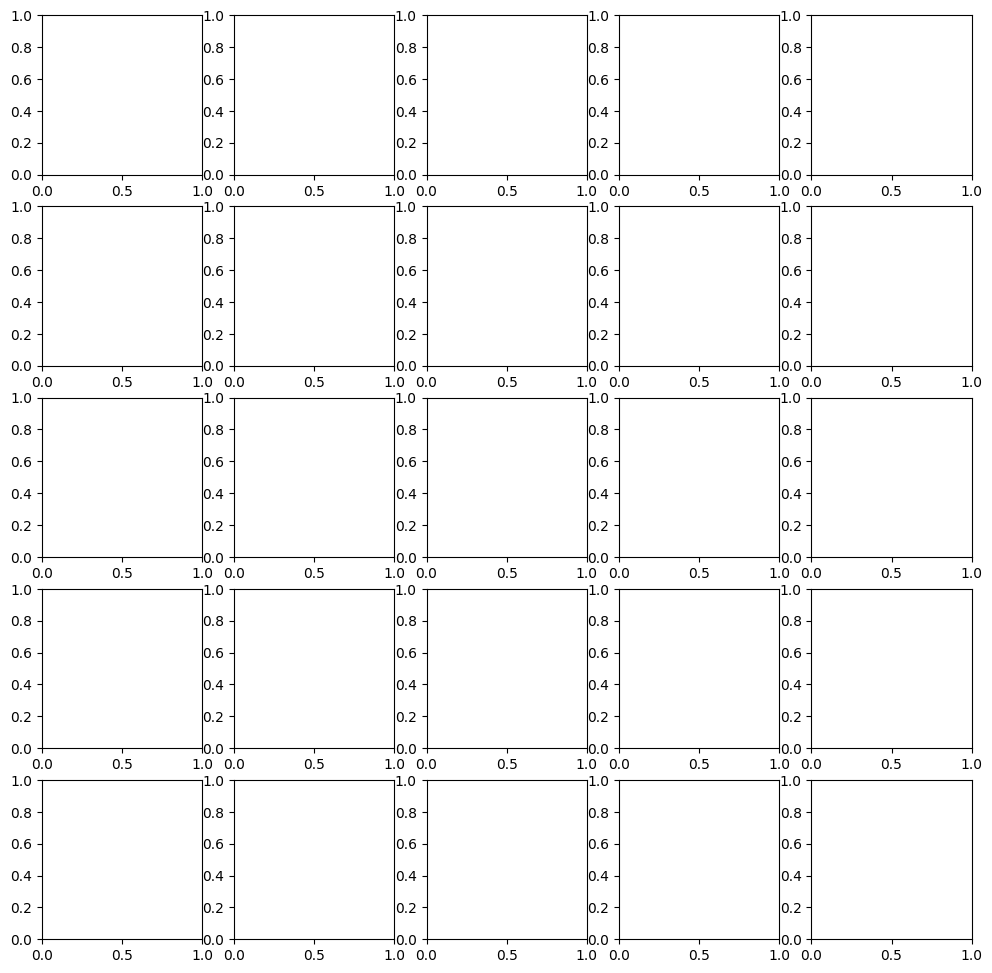

In [18]:
# Let's see how it does on the test set:
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

y_pred = model.predict(x_test[:R*C, :,:,:])
y_pred = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test, axis=1)
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_num_to_str[y_test_int[i]], class_num_to_str[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [16]:
# Accuracy on full test set:
y_pred_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_test_vals = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred_test == y_test_vals)
print(f"Accuracy on test set: {accuracy:.4f}")

313/313 [==============================] - 0s 847us/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [15]:
y_test

array([3, 8, 8, ..., 5, 1, 7])